In [443]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import random
%matplotlib inline

In [444]:
words = open('names.txt', 'r').read().splitlines()
dataset_size = len(words)
print(f'{dataset_size=}')
words[:8]

dataset_size=32033


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [445]:
# build vocabulary of characters and mapping to/from integers
special_character = '.'
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i,s in enumerate(chars)} # string to int
stoi[special_character] = 0
itos = {i: s for s, i in stoi.items()} # int to string

In [446]:
# build dataset
def build_dataset(words: list[str], block_size: int = 3):
    X, y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + special_character:
            idx = stoi[ch]
            X.append(context)
            y.append(idx)
            context = context[1:] + [idx]
    
    X, y = torch.tensor(X), torch.tensor(y)
    print(f'{X.shape=}, {y.shape=}')
    return X, y

random.seed(42)
random.shuffle(words)
n1 = int(dataset_size*.8)
n2 = int(dataset_size*.9)
X_train, y_train = build_dataset(words[:n1])
X_dev, y_dev = build_dataset(words[n1:n2])
X_test, y_test = build_dataset(words[n2:])

X.shape=torch.Size([182625, 3]), y.shape=torch.Size([182625])
X.shape=torch.Size([22655, 3]), y.shape=torch.Size([22655])
X.shape=torch.Size([22866, 3]), y.shape=torch.Size([22866])


## Initialize the model

In [447]:
# implementing the hidden layer
g = torch.Generator().manual_seed(2147483647) # for reproducibility
V = len(stoi.items())
neurons = 300
embedding_size = 10
block_size = 3
sample_size = X_train.shape[0]

# initial random embeddings
C = torch.randn((V,embedding_size))

# look up the embeddings for the training data
emb = C[X_train]

# initialise the learnable parameters of the first layer of neurons
W1 = torch.randn((block_size*embedding_size, neurons), generator=g)
b1 = torch.randn(neurons, generator=g)

# flatten the embeddings to concatenate the vector for each input character giving us a n x (embedding size x block size) matrix
emb_reshaped = emb.view((sample_size, block_size*embedding_size))

# apply activation function
h = torch.tanh(emb_reshaped @ W1 + b1)

# start implementing the output layer by randomly initializing the learnable parameters
W2 = torch.randn((neurons, V), generator=g)
b2 = torch.randn(V, generator=g)
logits = h @ W2 + b2
# Manual implementation of cross entropy that's less efficient and doesn't regularise to prevent explosions towards infinity for high logit values
# counts = logits.exp()
# counts.shape
# prob = counts /counts.sum(1, keepdim=True)
loss = F.cross_entropy(logits, y_train)
parameters = [C, W1, b1, W2, b2]
parameter_count = sum([p.nelement() for p in parameters])
print(f'{parameter_count=}')
for p in parameters:
    p.requires_grad = True
    
# initialise tracking datasets
lru = []
losses = []
loss

parameter_count=17697


tensor(29.5216)

## Train the model

In [454]:
learning_rate = 0.01
iterations = 50000
batch_size = 32000
start = time.time()

lre = torch.linspace(-3, 0 ,iterations)
lrs = 10**lre

for i in range(iterations):
    mini_batch_indexes = torch.randint(0, X_train.shape[0], (batch_size,))
    # forward pass
    emb = C[X_train[mini_batch_indexes]]
    h = torch.tanh(emb.view(-1, block_size*embedding_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[mini_batch_indexes])
    if i % 10 == 0:
        print(f'iteration: {i}, loss = {loss}')
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update 
    for p in parameters:
        # p.data += -lrs[i] * p.grad
        p.data += -learning_rate * p.grad
        
    # track stats
    lru.append(lre[i])
    losses.append(loss.log10().item())
        
end = time.time()
length = end - start
print(f'Took {length:.{2}} seconds')

# Calculate training set loss
emb = C[X_train]
h = torch.tanh(emb.view(-1, block_size*(embedding_size)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_train)
print(f'Full batch lost {loss=}')
plt.plot(range(len(losses)),losses)

iteration: 0, loss = 2.3337550163269043
iteration: 10, loss = 2.282813549041748
iteration: 20, loss = 2.2773189544677734
iteration: 30, loss = 2.275055408477783
iteration: 40, loss = 2.26460337638855
iteration: 50, loss = 2.2716212272644043
iteration: 60, loss = 2.273630380630493
iteration: 70, loss = 2.268428087234497
iteration: 80, loss = 2.2807369232177734
iteration: 90, loss = 2.28108286857605
iteration: 100, loss = 2.272984266281128
iteration: 110, loss = 2.260239362716675
iteration: 120, loss = 2.2818644046783447
iteration: 130, loss = 2.2772140502929688
iteration: 140, loss = 2.2717490196228027
iteration: 150, loss = 2.2839276790618896
iteration: 160, loss = 2.270928382873535
iteration: 170, loss = 2.2665140628814697
iteration: 180, loss = 2.2756974697113037
iteration: 190, loss = 2.2599120140075684
iteration: 200, loss = 2.2745578289031982
iteration: 210, loss = 2.2623424530029297
iteration: 220, loss = 2.254526138305664
iteration: 230, loss = 2.2623696327209473
iteration: 240,

KeyboardInterrupt: 

In [455]:
# Calculate dev set loss
emb = C[X_dev]
h = torch.tanh(emb.view(-1, block_size*embedding_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_dev)
print(f'Full batch lost {loss=}')

Full batch lost loss=tensor(2.2762, grad_fn=<NllLossBackward0>)


In [456]:
C.shape

torch.Size([27, 10])

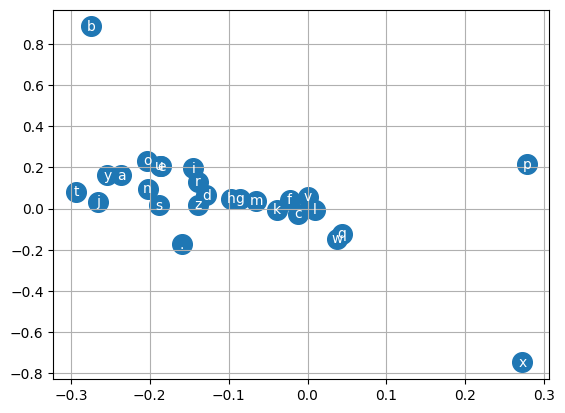

In [457]:
# Only works if embedding size = 2
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [458]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carperfato.
hari.
kimle.
reh.
cassanden.
jazonen.
delyah.
jarqai.
nerania.
chaiivin.
leig.
dham.
join.
quinn.
shoilea.
jadbiuo.
jero.
dearyximah.
eunirraton.
deci.
